In [1]:
from werkzeug.wrappers import Request, Response
#from flask import Flask, render_template
from jinja2 import Template

#from datetime import date
from datetime import datetime, timedelta

import collections
from amigocloud import AmigoCloud

from datetime import datetime

from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

ModuleNotFoundError: No module named 'amigocloud'

In [2]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [3]:
def generar_reporte(codigo_canhero):
    # EXTRAER DATOS DE CREDITO
    query_credito = {'query': 'select * from dataset_307560 where cast(SPLIT_PART(canhero, \'/\', 1) as integer) = {cod_ca}'.format(cod_ca=codigo_canhero)}
    credito_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_credito)
    credito_data = credito_select['data'][0]
    credito_data['fecha_informe'] = datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
    credito_data['fecha_2da_insp'] = datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
    credito = collections.namedtuple("credito", credito_data.keys())(*credito_data.values())

    # EXTRAER DATOS DE PROPIEDADES
    # query_propiedades = {'query': 'select * from dataset_282968 where cre_ref_prop = \'{cre_ref_prop}\''.format(cre_ref_prop=credito.amigo_id)}
    query_propiedades = {'query': 'select prop.propiedad, prop.amigo_id from dataset_307562 prop inner join dataset_307563 lotes on lotes.prop_ref_lote=prop.amigo_id where insp_ref_prop=\'{cre_ref_prop}\' and (lotes.estado_de_siembra=\'CAÑA NACIDA\' or lotes.estado_de_siembra=\'CAÑA NO NACIDA\') group by prop.propiedad, prop.amigo_id'.format(cre_ref_prop=credito.amigo_id)}
    propiedades_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_propiedades)    
    
    propiedades_data = propiedades_select['data']

    # EXTRAER DATOS DE LOTES
    propiedades = []
    for prop in propiedades_data:
        prop['lotes'] = []
        query_lotes = {'query': 'select * from dataset_307563 where prop_ref_lote=\'{prop_ref_lote}\' and (estado_de_siembra=\'CAÑA NACIDA\' or estado_de_siembra=\'CAÑA NO NACIDA\')'.format(prop_ref_lote=prop['amigo_id'])}
        lotes_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_lotes)
        for lote_select in lotes_select['data']:
            lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
            prop['lotes'].append(lote)
        propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))

    # EXTRAER FOTOS
    fotos = []
    for propiedad in propiedades:
        for lote in propiedad.lotes:
            print(lote.lote, lote.amigo_id)
            query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_48961 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
            fotos_filename = amigocloud.get('https://app.amigocloud.com/api/v1/projects/32672/sql', query_fotos)
            if fotos_filename['data'] != []:
                dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
                fotos.append(dic)

    # GENERERAR PLANOS
    i = 0
    lista_planos = []
    for propiedad in propiedades:
        i = i + 1
        lista_planos.append(generar_plano(propiedad, i))


    # GENERAR REPORTE
    doc = DocxTemplate(ruta + "/templates/tpl_inf_credito_2da.docx")
    #generar lista de InlineImage de planos 
    lista_InlineImage = []
    for plano in lista_planos:
        lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))
    #descargar fotos y generar lista InlineImage
    lista_fotos_inline = []
    for foto in fotos:
        #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        file = open(ruta + '/fotos/' + foto['file_name'], "wb")
        file.write(response.content)
        file.close()
        lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor=ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})
    firma_respon = None
    if credito.respon_2da_insp == 'Juan Pablo Jaldin Duran':
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))
    else:
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
    context = {'credito':credito, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}
    doc.render(context)
    cod_ca = credito.canhero.split(' / ')[0]
    nom_ca = credito.canhero.split(' / ')[1]
    file_name = file_name = '_' + cod_ca + '_CRS_' + credito.fecha_2da_insp.replace('/', '-') + '_' + nom_ca + '_' + str(credito.id)
    doc.save(ruta + '/informes/' + file_name + '.docx')

In [4]:
def generar_plano(propiedad, i):
    lotes_lista = []
    for lote in propiedad.lotes:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)
    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)
    
    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    
    print('aqui')
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    ruta_plano = ruta + '/planos/' + str(propiedad.amigo_id) + '.jpeg'
    fig.savefig(ruta_plano, dpi = 300, bbox_inches='tight')
    plt.clf()
    
    return ruta_plano

In [5]:
semana = 'S39'
query = {'query': 'select split_part(canhero, \' / \', 1) cod, split_part(canhero, \' / \', 2) nom from dataset_307560 where semana_2da = \'{sem}\''.format(sem=semana)}
project = 'https://app.amigocloud.com/api/v1/projects/32672/sql'
select = amigocloud.get(project, query)
data = select['data']

In [6]:
data

[{'cod': '5385', 'nom': 'HUANCA CANO MARIA '},
 {'cod': '42034', 'nom': 'ACSAMA MAMANI TEODORA'},
 {'cod': '388', 'nom': 'AGROPECUARIA MARIANA S.R.L. '},
 {'cod': '2408', 'nom': 'CHOQUE CACERES FREDDY'},
 {'cod': '42154', 'nom': 'PIZARRO CABRERA ARMANDO CESAR'},
 {'cod': '4844', 'nom': 'TARRADELLES MARTINEZ DIETER JORGE'},
 {'cod': '7519', 'nom': 'LEON ALVAREZ REMY '},
 {'cod': '13002', 'nom': 'SEJAS SALVATIERRA JULIO CESAR '},
 {'cod': '6457', 'nom': 'JORDAN TONDELLY RODOLFO '}]

In [7]:
# lista = [430, 40270, 13132, 874, 41966, 11798, 41544, 14993, 644, 1068, 13763, 2220, 1858, 2719]
lista = [i['cod'] for i in data]

In [9]:
lista = ['4844', '7519', '13002', '6457']

In [ ]:
for i in lista:
    generar_reporte(i)
    print('======================', i)

L14 dc278dd4db0440f9a65cb9a58b111e88
L12 ae7abff2ad614516a3b6910f4cf2f590
L13 8485b686514a4223b6e203290d34c935
L1 8ba02dfecd7e4cdf9db4181a889161dd


C:\Users\bismarksr\anaconda3\envs\utea_amigocloud\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


In [11]:
%matplotlib inline

import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

In [ ]:
data_url = "https://ndownloader.figshare.com/files/20232174"

In [13]:
db = geopandas.read_file(data_url)

In [14]:
db

,city_id,n_buildings,geometry
0,ci000,2348,"POLYGON ((385390.071 4202949.446, 384488.697 4..."
1,ci001,2741,"POLYGON ((214893.033 4579137.558, 215258.185 4..."
2,ci002,5472,"POLYGON ((690674.281 4182188.538, 691047.526 4..."
3,ci003,14608,"POLYGON ((513378.282 4072327.639, 513408.853 4..."
4,ci004,2324,"POLYGON ((206989.081 4129478.031, 207275.702 4..."
...,...,...,...
712,ci858,1755,"POLYGON ((936758.235 4650353.917, 937046.524 4..."
713,ci860,2419,"POLYGON ((191152.366 4715533.725, 191009.949 4..."
714,ci869,2187,"POLYGON ((981306.101 4644778.993, 981468.164 4..."
715,ci880,1986,"POLYGON ((592194.932 4676275.761, 592766.349 4..."


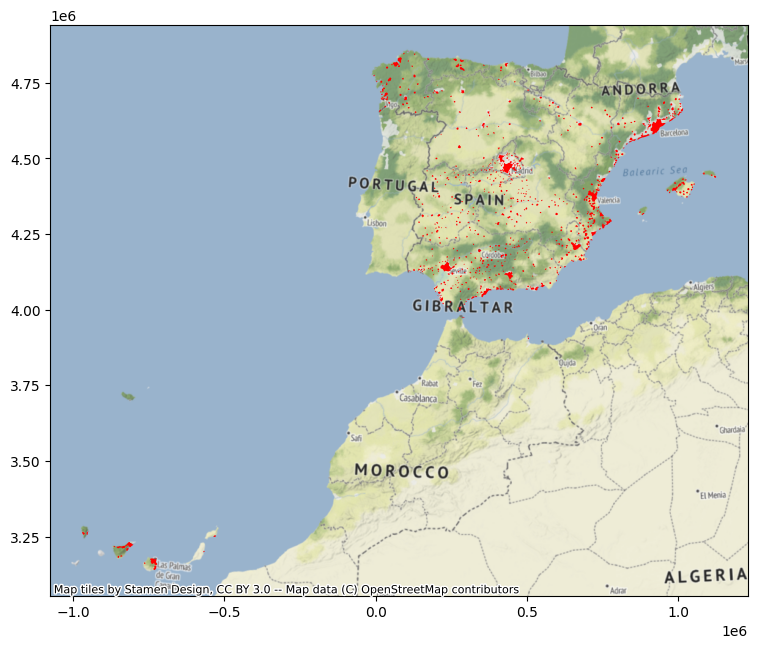

In [15]:
ax = db.plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=db.crs.to_string())

In [17]:
cx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<ins

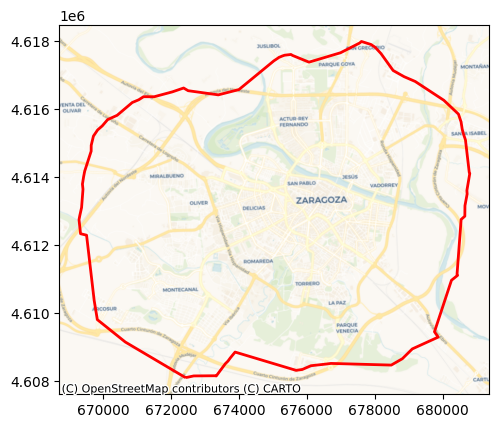

In [19]:
zaragoza = db.query("city_id == 'ci122'")
ax = zaragoza.plot(facecolor="none",
                   edgecolor="red",
                   linewidth=2
                  )
cx.add_basemap(ax,
               crs=zaragoza.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )